In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
full_df = pd.read_hdf('race1.hd5')
df2 = full_df['GBR'].copy()

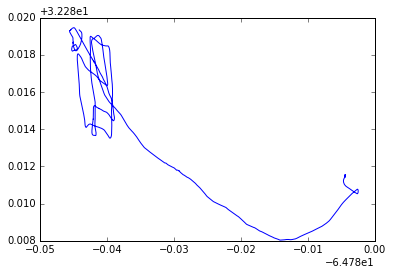

In [3]:
plt.plot(df2.Lon, df2.Lat)

In [4]:
def correct_angle(ser):
    wd_df = pd.DataFrame({'cwd': ser.copy()})
    wd_df['low_5s'] = wd_df['cwd'] < 5
    wd_df['high_355s'] = wd_df['cwd'] > 355
    wd_df['low_to_high'] = wd_df['low_5s'].shift(1) & wd_df['high_355s']
    wd_df['high_to_low'] = wd_df['high_355s'].shift(1) & wd_df['low_5s']
    wd_df['cwd_correction_dir'] = 0
    wd_df['cwd_correction_dir'][wd_df['high_to_low']] = 1
    wd_df['cwd_correction_dir'][wd_df['low_to_high']] = -1
    wd_df['cwd_correction'] = wd_df['cwd_correction_dir'].cumsum() * 360
    wd_df['corrected'] = wd_df['cwd'] + wd_df['cwd_correction']
    return wd_df['corrected'], wd_df['cwd_correction']


In [5]:
df2['CWD'] = df2['CourseWindDirection']
df2['C_CWD'], wind_correction = correct_angle(df2['CourseWindDirection'])
df2['C_COG'], c_correction = correct_angle(df2['COG'])
#df2['l180'] = 180
#df2['l-180'] = -180
df2['CB_CWD'] =  df2['CWD'] - c_correction # coursewind - course correction
df2['CW_COG'] = df2['COG'] - wind_correction
df2['WC_DIFF'] = (df2['CB_CWD'] - df2['CW_COG'])
df2['WC_DIFF180'] = df2['WC_DIFF'] % 180

/Users/paddy/anaconda/envs/joe_demo/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paddy/anaconda/envs/joe_demo/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:

tacks = df2[df2['WC_DIFF180'] <1].index.values
tacks

array(['2017-05-09T10:50:21.600000000-0400',
       '2017-05-09T10:51:05.000000000-0400',
       '2017-05-09T10:53:41.000000000-0400',
       '2017-05-09T10:53:58.000000000-0400',
       '2017-05-09T10:53:58.200000000-0400',
       '2017-05-09T10:54:27.400000000-0400',
       '2017-05-09T10:59:28.800000000-0400',
       '2017-05-09T11:01:08.800000000-0400',
       '2017-05-09T11:08:24.000000000-0400',
       '2017-05-09T11:12:06.800000000-0400',
       '2017-05-09T11:14:23.400000000-0400',
       '2017-05-09T11:36:06.200000000-0400',
       '2017-05-09T11:38:51.400000000-0400'], dtype='datetime64[ns]')

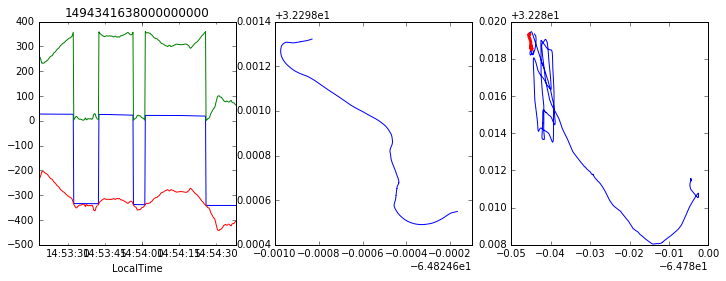

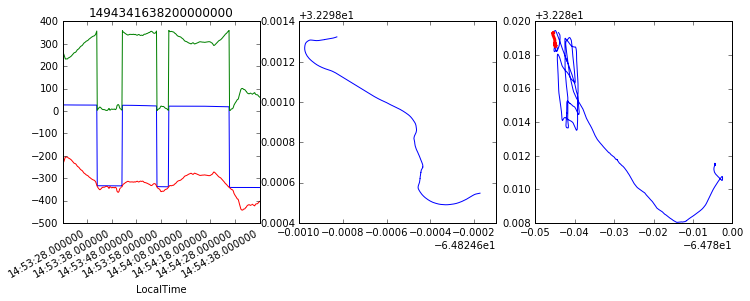

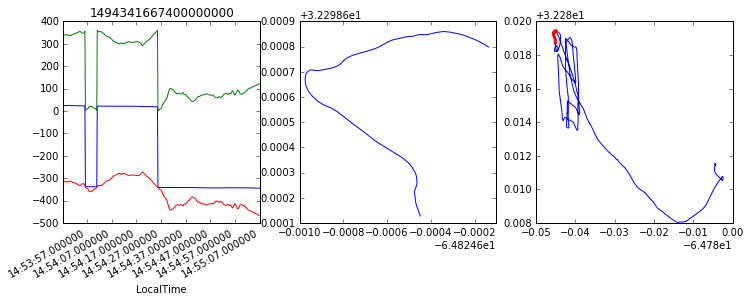

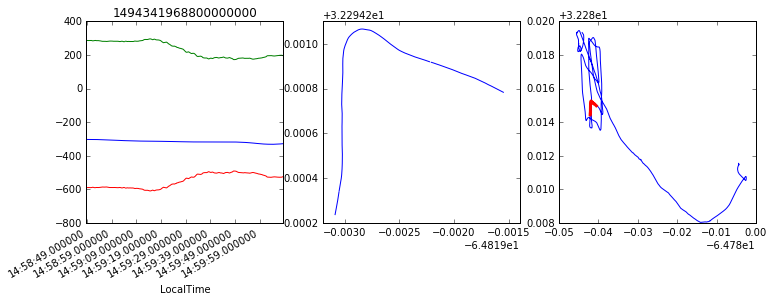

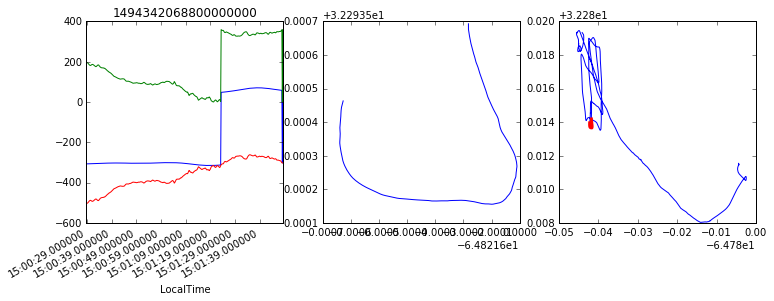

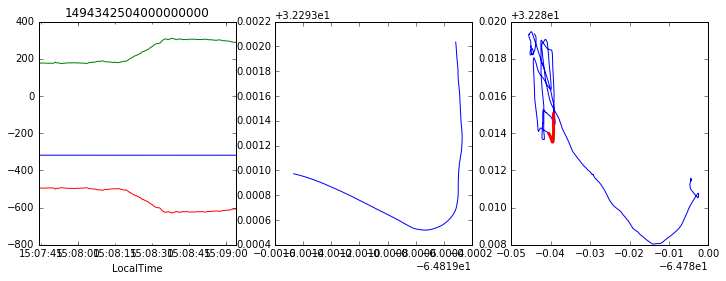

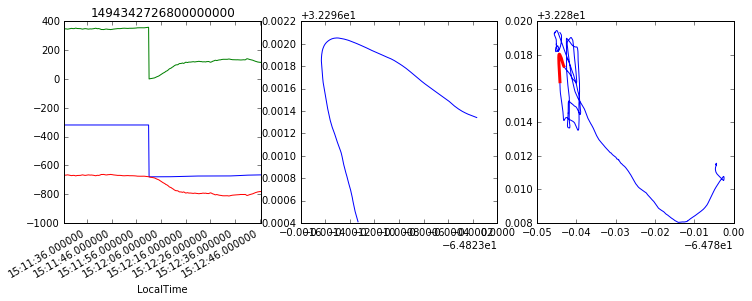

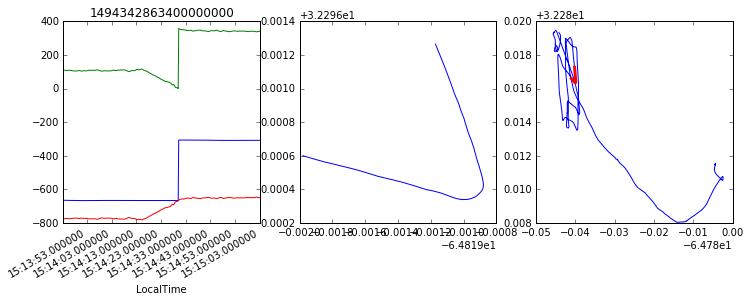

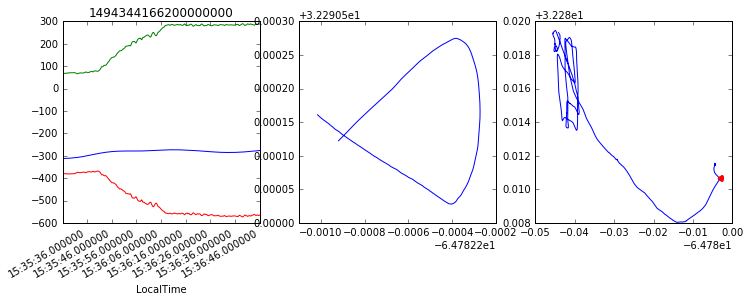

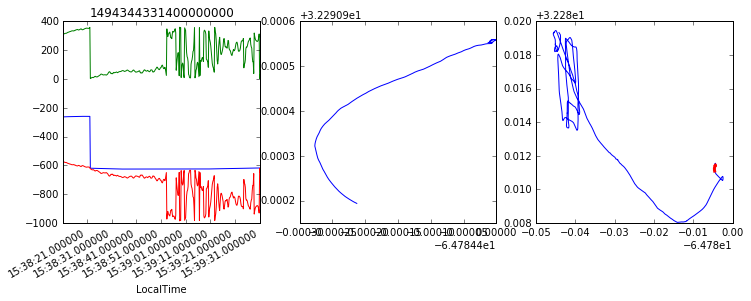

In [13]:
for tstamp in tacks[3:]:

    t_idx = df2.index.get_loc(tstamp)
    start, end = t_idx - 200, t_idx + 200
    df3 = df2.ix[start:end]
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    ax1, ax2, ax3 = ax
    
    df3.CB_CWD.plot(title="%d" % tstamp, ax=ax1)
    df3.CW_COG.plot(color='green', ax=ax1)
    df3.WC_DIFF.plot(color='red', ax=ax1)
    #plt.figure()
    ax2.plot(df3.Lon, df3.Lat)

    ax3.plot(df2.Lon, df2.Lat, color='blue')
    ax3.plot(df3.Lon, df3.Lat, color='red', linewidth=3.0)
    
    #plt.figure()